# Data

**Imaging Data Description**

All BraTS multimodal scans are available as NIfTI files (.nii.gz) and describe a) native (T1) and b) post-contrast T1-weighted (T1Gd), c) T2-weighted (T2), and d) T2 Fluid Attenuated Inversion Recovery (T2-FLAIR) volumes, and were acquired with different clinical protocols and various scanners from multiple (n=19) institutions, mentioned as data contributors here.

All the imaging datasets have been segmented manually, by one to four raters, following the same annotation protocol, and their annotations were approved by experienced neuro-radiologists. Annotations comprise the GD-enhancing tumor (ET — label 4), the peritumoral edema (ED — label 2), and the necrotic and non-enhancing tumor core (NCR/NET — label 1), as described both in the BraTS 2012-2013 TMI paper and in the latest BraTS summarizing paper. The provided data are distributed after their pre-processing, i.e., co-registered to the same anatomical template, interpolated to the same resolution (1 mm^3) and skull-stripped.


## Load data + Samples

In [1]:
# Import libraries

import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import data
import nibabel as nib
import requests
import io
import random, zipfile
import torch
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
MODALITIES = ['flair', 't1', 't1ce', 't2']

# 1) Extract if needed: kaggel or colab
extract_path = "/kaggle/input/imiap-u-net"
# zip_path     = "/content/drive/MyDrive/train_data.zip"
# extract_path = "/content/drive/MyDrive/train_data"
if not os.path.isdir(extract_path):
    print(f"Extracting {zip_path} → {extract_path} …")
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(extract_path)
    print("Done.")
else:
    print("Already extracted.")

# 2) Fixed Dataset that grabs every subdirectory:
class BraTSDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        # List any immediate subdirectory
        self.folders = sorted(
            [os.path.join(root_dir, d)
             for d in os.listdir(root_dir)
             if os.path.isdir(os.path.join(root_dir, d))]
        )
        if len(self.folders) == 0:
            raise RuntimeError(f"No subfolders found in {root_dir}")
        self.transform = transform

    def __len__(self):
        return len(self.folders)

    def __getitem__(self, idx):
        folder = self.folders[idx]
        base   = os.path.basename(folder)

        # load and normalize modalities into x of shape (4, H, W, 1)
        scans = []
        for m in MODALITIES:
            img = nib.load(os.path.join(folder, f"BraTS20_Training_{base}_{m}.nii")).get_fdata()
            img = (img - img.min()) / (img.max() - img.min())
            scans.append(img.astype(np.float32))
        x = np.stack(scans, axis=0)

        # load seg of shape (H, W, 1)
        y = nib.load(os.path.join(folder, f"BraTS20_Training_{base}_seg.nii")).get_fdata()
        y = (y > 0).astype(np.float32)

        # optional augment
        if self.transform:
            x, y = self.transform(x, y)

        # —— Squeeze singleton “slice” dimension ——
        if x.ndim == 4 and x.shape[-1] == 1:
            x = x[..., 0]
        if y.ndim == 3 and y.shape[-1] == 1:
            y = y[..., 0]

        x_tensor = torch.from_numpy(x)               # → (4, H, W)
        y_tensor = torch.from_numpy(y).unsqueeze(0)  # → (1, H, W)

        return x_tensor, y_tensor

# 3) Simple random flip/rotate
def random_flip_rotate(x, y):
    if random.random() > 0.5:
        x = np.flip(x, axis=2).copy()
        y = np.flip(y, axis=1).copy()
    if random.random() > 0.5:
        x = np.rot90(x, k=1, axes=(1,2)).copy()
        y = np.rot90(y, k=1, axes=(0,1)).copy()
    return x, y

# 4) Instantiate, split, and DataLoaders
root = extract_path
dataset = BraTSDataset(root_dir=root)

val_frac = 0.2
n_total  = len(dataset)
n_val    = int(n_total * val_frac)
n_train  = n_total - n_val

train_ds, val_ds = random_split(dataset, [n_train, n_val])
train_ds.dataset.transform = random_flip_rotate
val_ds.dataset.transform   = None

train_dataloader = DataLoader(train_ds, batch_size=8, shuffle=True,  num_workers=2)
val_dataloader   = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2)

print(f"Found {n_total} cases → {n_train} train / {n_val} val.")


Already extracted.
Found 354 cases → 284 train / 70 val.


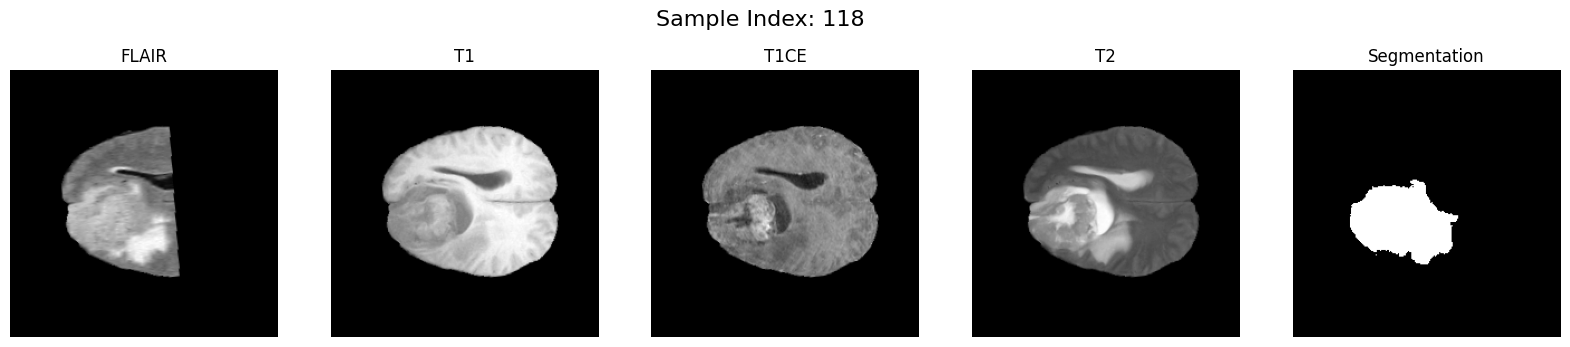

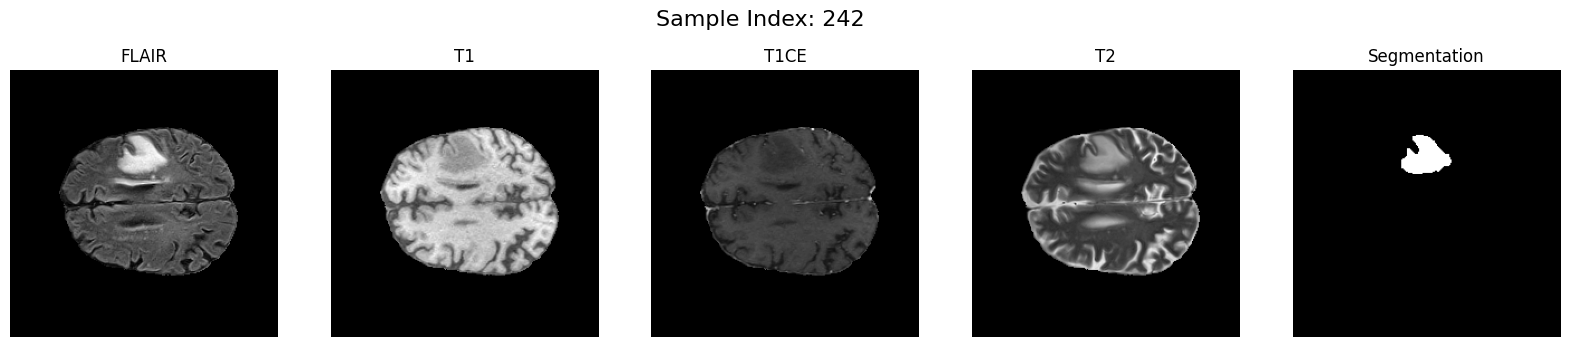

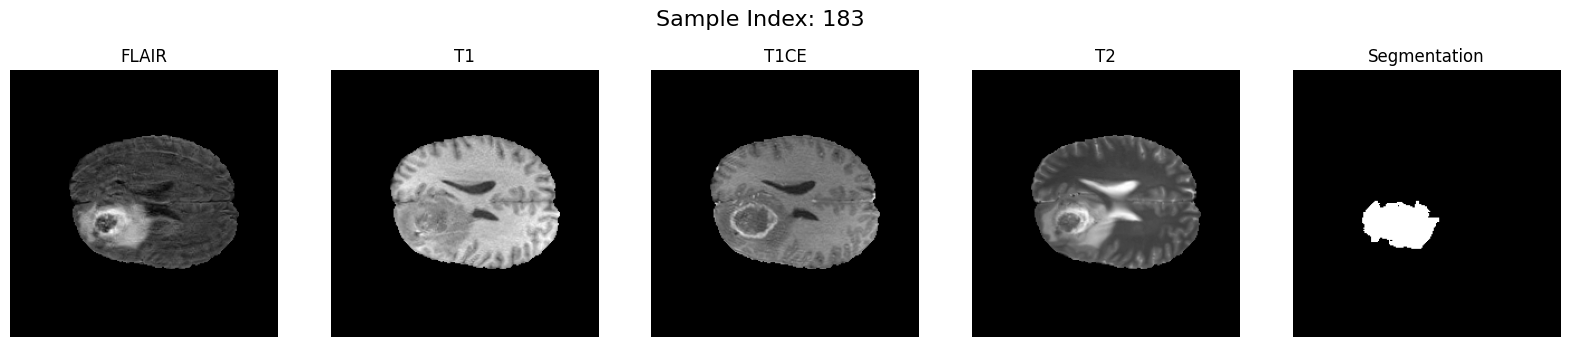

In [3]:
import matplotlib.pyplot as plt

def plot_sample(dataset, index=0):
    x, y = dataset[index]  # x shape: [4, H, W], y shape: [1, H, W]
    modalities = ['FLAIR', 'T1', 'T1CE', 'T2']
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))

    for i in range(4):
        axes[i].imshow(x[i], cmap='gray')
        axes[i].set_title(modalities[i])
        axes[i].axis('off')

    axes[4].imshow(y[0], cmap='gray')
    axes[4].set_title("Segmentation")
    axes[4].axis('off')

    plt.suptitle(f"Sample Index: {index}", fontsize=16)
    plt.show()

# Plot 3 random training samples
for idx in np.random.choice(len(train_ds), 3, replace=False):
    plot_sample(train_ds, idx)


# <a id='toc1_3_3_'></a>[U-Net Model](#toc0_)


**U-Net** is a fully convolutional neural network originally designed for semantic image segmentation of biomedical images. This network features a distinctive encoder-decoder structure, making it exceptionally effective for detailed and precise image analysis tasks in the medical field. Since its inception, U-Net has been widely recognized for its robust performance in segmenting complex anatomical structures in medical scans, such as MRIs and CT images.

The architecture of U-Net is particularly notable for its ability to capture contextual information at various scales, which is crucial for accurate segmentation. The encoder part of the network progressively reduces the spatial dimension of the image, capturing high-level semantic information. Conversely, the decoder part gradually recovers object details and spatial dimensions, ensuring precise localization.

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/Kk-yKGkvRtkNzLkZdP3Pag/unet.png" width="70%" alt="indexing"/>

**Reference:**
1. Original Paper: [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)


**1. Input Image Tile**  
- **Dimensions**: 572 × 572, with 1 channel (grayscale)  
- Serves as the input to the U-Net for segmentation  
- Passes through convolution and pooling layers for feature extraction  

**2. Convolution Blocks (Conv 3×3, ReLU)**  
- Represented by pairs of 3×3 convolutions followed by ReLU activation  
- Feature map depth increases: 64 → 128 → 256 → 512 → 1024  
- Responsible for extracting hierarchical image features  

**3. Downsampling (Max Pool 2×2)**  
- Reduces spatial dimensions by a factor of 2  
- Retains the most prominent features while losing spatial detail  
- Forms the contracting path on the left  

**4. Bottleneck**  
- Central part of the architecture  
- Has the deepest feature maps with highest abstraction  
- Balances context with reduced resolution  

**5. Upsampling (Up-Conv 2×2)**  
- Increases spatial dimensions by a factor of 2  
- Reduces feature map depth while restoring resolution  
- Forms the expanding path on the right  

**6. Copy and Crop / Skip Connections**  
- Copies feature maps from the contracting path and crops them to match dimensions  
- Concatenates them with upsampled maps to preserve spatial accuracy  
- Combines deep semantic information with shallow spatial detail  

**7. Output Convolution (1×1 Conv)**  
- Applies a 1×1 convolution to map each pixel to output classes  
- Final result is a pixel-wise classification map  
- Enables precise segmentation boundaries  

**Summary Table**

| **Stage**           | **Operation**                 | **Purpose**                              |
|---------------------|-------------------------------|------------------------------------------|
| Input               | Image tile                    | Input for segmentation                   |
| Contracting Path    | Conv 3×3, ReLU + MaxPool      | Feature extraction and downsampling      |
| Bottleneck          | Deepest layer                 | Global context representation            |
| Expanding Path      | Up-conv + Skip connections    | Resolution recovery and spatial merging  |
| Output Layer        | 1×1 convolution               | Pixel-wise classification                |


## Network

Let's construct a U-Net model for the dataset.

In [ ]:
import torch.nn as nn

def double_convolution(in_ch, out_ch):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )

class UNet(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        self.enc1 = double_convolution(4, 64)
        self.enc2 = double_convolution(64, 128)
        self.enc3 = double_convolution(128,256)
        self.enc4 = double_convolution(256,512)
        self.center = double_convolution(512,1024)
        self.pool = nn.MaxPool2d(2)
        self.up1 = nn.ConvTranspose2d(1024,512,2,2)
        self.dec1 = double_convolution(1024,512)
        self.up2 = nn.ConvTranspose2d(512,256,2,2)
        self.dec2 = double_convolution(512,256)
        self.up3 = nn.ConvTranspose2d(256,128,2,2)
        self.dec3 = double_convolution(256,128)
        self.up4 = nn.ConvTranspose2d(128,64,2,2)
        self.dec4 = double_convolution(128,64)
        self.out = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        c = self.center(self.pool(e4))
        d1 = self.dec1(torch.cat([self.up1(c), e4], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d1), e3], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d2), e2], dim=1))
        d4 = self.dec4(torch.cat([self.up4(d3), e1], dim=1))
        return self.out(d4)


## Loss

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        num = 2*(inputs*targets).sum(dim=(1,2,3)) + self.smooth
        den = inputs.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3)) + self.smooth
        return 1 - (num/den).mean()

class DiceBCELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self, inputs, targets):
        return self.bce(inputs, targets) + self.dice(inputs, targets)


## Train

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- 1️⃣ Define three criterions ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
losses = {
    'BCE': nn.BCEWithLogitsLoss(),
    'Dice': DiceLoss(),
    'BCE+Dice': DiceBCELoss()
}

results = {}

epochs = 20
for name, criterion in losses.items():
    print(f"\nTraining with {name} Loss\n{'='*40}")
    model = UNet(num_classes=1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    train_losses, val_losses, train_dices, val_dices = [], [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss, running_dice = 0.0, 0.0
        for data, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs} - {name} Training"):
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            preds = torch.sigmoid(outputs) > 0.5
            dice_score = 1 - DiceLoss()(outputs, labels).item()
            running_dice += dice_score

        train_losses.append(running_loss / len(train_dataloader))
        train_dices.append(running_dice / len(train_dataloader))

        model.eval()
        val_loss, val_dice = 0.0, 0.0
        with torch.no_grad():
            for data, labels in tqdm(val_dataloader, desc="Validation"):
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = torch.sigmoid(outputs) > 0.5
                dice_score = 1 - DiceLoss()(outputs, labels).item()
                val_dice += dice_score

        val_losses.append(val_loss / len(val_dataloader))
        val_dices.append(val_dice / len(val_dataloader))

        print(f"[{name}] Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f} | Val Loss={val_losses[-1]:.4f} | Train Dice={train_dices[-1]:.4f} | Val Dice={val_dices[-1]:.4f}")

    results[name] = {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_dices': train_dices,
        'val_dices': val_dices
    }



Training with BCE Loss


Validation: 100%|██████████| 9/9 [00:01<00:00,  4.97it/s]


[BCE] Epoch 1: Train Loss=0.5194 | Val Loss=0.2367 | Train Dice=0.0314 | Val Dice=0.0027


Validation: 100%|██████████| 9/9 [00:00<00:00,  9.80it/s]


[BCE] Epoch 2: Train Loss=0.1294 | Val Loss=0.0961 | Train Dice=0.0392 | Val Dice=0.1104


Validation: 100%|██████████| 9/9 [00:00<00:00,  9.54it/s]


[BCE] Epoch 3: Train Loss=0.0734 | Val Loss=0.0697 | Train Dice=0.1485 | Val Dice=0.2398


Validation: 100%|██████████| 9/9 [00:00<00:00,  9.90it/s]


[BCE] Epoch 4: Train Loss=0.0602 | Val Loss=0.0612 | Train Dice=0.2476 | Val Dice=0.3312


Validation: 100%|██████████| 9/9 [00:00<00:00,  9.94it/s]


[BCE] Epoch 5: Train Loss=0.0549 | Val Loss=0.0537 | Train Dice=0.3063 | Val Dice=0.4015


Validation: 100%|██████████| 9/9 [00:00<00:00,  9.90it/s]


[BCE] Epoch 6: Train Loss=0.0473 | Val Loss=0.0538 | Train Dice=0.3900 | Val Dice=0.4661


Validation: 100%|██████████| 9/9 [00:00<00:00, 10.12it/s]


[BCE] Epoch 7: Train Loss=0.0461 | Val Loss=0.0428 | Train Dice=0.4647 | Val Dice=0.5948


Validation: 100%|██████████| 9/9 [00:00<00:00, 10.08it/s]


[BCE] Epoch 8: Train Loss=0.0455 | Val Loss=0.0446 | Train Dice=0.4848 | Val Dice=0.5082


Validation: 100%|██████████| 9/9 [00:00<00:00, 10.00it/s]


[BCE] Epoch 9: Train Loss=0.0400 | Val Loss=0.0333 | Train Dice=0.5386 | Val Dice=0.6764


Validation: 100%|██████████| 9/9 [00:00<00:00, 10.26it/s]


[BCE] Epoch 10: Train Loss=0.0455 | Val Loss=0.0489 | Train Dice=0.5323 | Val Dice=0.4344


Validation: 100%|██████████| 9/9 [00:00<00:00, 10.07it/s]


[BCE] Epoch 11: Train Loss=0.0446 | Val Loss=0.0400 | Train Dice=0.4267 | Val Dice=0.5468


Validation: 100%|██████████| 9/9 [00:00<00:00,  9.91it/s]


[BCE] Epoch 12: Train Loss=0.0391 | Val Loss=0.0367 | Train Dice=0.5146 | Val Dice=0.5717


Validation: 100%|██████████| 9/9 [00:00<00:00, 10.28it/s]


[BCE] Epoch 13: Train Loss=0.0384 | Val Loss=0.0334 | Train Dice=0.5372 | Val Dice=0.6492


Validation: 100%|██████████| 9/9 [00:00<00:00, 10.11it/s]


[BCE] Epoch 14: Train Loss=0.0366 | Val Loss=0.0326 | Train Dice=0.5585 | Val Dice=0.6699


Validation: 100%|██████████| 9/9 [00:00<00:00, 10.18it/s]


[BCE] Epoch 15: Train Loss=0.0336 | Val Loss=0.0329 | Train Dice=0.6103 | Val Dice=0.6984


Validation: 100%|██████████| 9/9 [00:00<00:00, 10.22it/s]


[BCE] Epoch 16: Train Loss=0.0348 | Val Loss=0.0312 | Train Dice=0.6056 | Val Dice=0.6812


Validation: 100%|██████████| 9/9 [00:00<00:00, 10.14it/s]


[BCE] Epoch 17: Train Loss=0.0352 | Val Loss=0.0296 | Train Dice=0.5942 | Val Dice=0.7087


Validation: 100%|██████████| 9/9 [00:00<00:00,  9.87it/s]


[BCE] Epoch 18: Train Loss=0.0353 | Val Loss=0.0339 | Train Dice=0.6097 | Val Dice=0.6983


Validation: 100%|██████████| 9/9 [00:00<00:00, 10.03it/s]


[BCE] Epoch 19: Train Loss=0.0336 | Val Loss=0.0313 | Train Dice=0.6284 | Val Dice=0.6635


Validation: 100%|██████████| 9/9 [00:00<00:00, 10.20it/s]


[BCE] Epoch 20: Train Loss=0.0305 | Val Loss=0.0289 | Train Dice=0.6252 | Val Dice=0.6816

Training with Dice Loss


Validation: 100%|██████████| 9/9 [00:00<00:00, 10.20it/s]


[Dice] Epoch 1: Train Loss=0.9456 | Val Loss=0.9066 | Train Dice=0.0544 | Val Dice=0.0934


Validation: 100%|██████████| 9/9 [00:00<00:00, 10.36it/s]


[Dice] Epoch 2: Train Loss=0.9406 | Val Loss=0.9999 | Train Dice=0.0594 | Val Dice=0.0001


Validation: 100%|██████████| 9/9 [00:00<00:00, 10.26it/s]


[Dice] Epoch 3: Train Loss=0.9999 | Val Loss=0.9999 | Train Dice=0.0001 | Val Dice=0.0001


Validation: 100%|██████████| 9/9 [00:00<00:00, 10.14it/s]


[Dice] Epoch 4: Train Loss=0.9999 | Val Loss=0.9999 | Train Dice=0.0001 | Val Dice=0.0001


Validation: 100%|██████████| 9/9 [00:00<00:00,  9.38it/s]


[Dice] Epoch 5: Train Loss=0.9999 | Val Loss=0.9999 | Train Dice=0.0001 | Val Dice=0.0001


Validation: 100%|██████████| 9/9 [00:00<00:00,  9.97it/s]


[Dice] Epoch 6: Train Loss=0.9999 | Val Loss=0.9999 | Train Dice=0.0001 | Val Dice=0.0001


Validation: 100%|██████████| 9/9 [00:00<00:00, 10.11it/s]


[Dice] Epoch 7: Train Loss=0.9999 | Val Loss=0.9999 | Train Dice=0.0001 | Val Dice=0.0001


Validation: 100%|██████████| 9/9 [00:04<00:00,  1.92it/s]


[Dice] Epoch 8: Train Loss=0.9999 | Val Loss=0.9999 | Train Dice=0.0001 | Val Dice=0.0001


Validation: 100%|██████████| 9/9 [00:00<00:00,  9.53it/s]


[Dice] Epoch 9: Train Loss=0.9999 | Val Loss=0.9999 | Train Dice=0.0001 | Val Dice=0.0001


Validation: 100%|██████████| 9/9 [00:00<00:00, 10.10it/s]


[Dice] Epoch 10: Train Loss=0.9999 | Val Loss=0.9999 | Train Dice=0.0001 | Val Dice=0.0001


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.99it/s]


[Dice] Epoch 11: Train Loss=0.9999 | Val Loss=0.9999 | Train Dice=0.0001 | Val Dice=0.0001


Validation: 100%|██████████| 9/9 [00:00<00:00,  9.97it/s]


[Dice] Epoch 12: Train Loss=0.9999 | Val Loss=0.9999 | Train Dice=0.0001 | Val Dice=0.0001


Validation: 100%|██████████| 9/9 [00:00<00:00, 10.11it/s]


[Dice] Epoch 13: Train Loss=0.9999 | Val Loss=0.9999 | Train Dice=0.0001 | Val Dice=0.0001


Validation: 100%|██████████| 9/9 [00:00<00:00,  9.95it/s]


[Dice] Epoch 14: Train Loss=0.9999 | Val Loss=0.9999 | Train Dice=0.0001 | Val Dice=0.0001


Validation: 100%|██████████| 9/9 [00:00<00:00,  9.93it/s]


[Dice] Epoch 15: Train Loss=0.9999 | Val Loss=0.9999 | Train Dice=0.0001 | Val Dice=0.0001


Validation: 100%|██████████| 9/9 [00:00<00:00, 10.11it/s]


[Dice] Epoch 16: Train Loss=0.9999 | Val Loss=0.9999 | Train Dice=0.0001 | Val Dice=0.0001


Validation: 100%|██████████| 9/9 [00:00<00:00, 10.02it/s]


[Dice] Epoch 17: Train Loss=0.9999 | Val Loss=0.9999 | Train Dice=0.0001 | Val Dice=0.0001


Validation: 100%|██████████| 9/9 [00:00<00:00,  9.87it/s]


[Dice] Epoch 18: Train Loss=0.9999 | Val Loss=0.9999 | Train Dice=0.0001 | Val Dice=0.0001


Validation: 100%|██████████| 9/9 [00:00<00:00,  9.81it/s]


[Dice] Epoch 19: Train Loss=0.9999 | Val Loss=0.9999 | Train Dice=0.0001 | Val Dice=0.0001


Validation: 100%|██████████| 9/9 [00:00<00:00, 10.13it/s]


[Dice] Epoch 20: Train Loss=0.9999 | Val Loss=0.9999 | Train Dice=0.0001 | Val Dice=0.0001

Training with BCE+Dice Loss


Validation: 100%|██████████| 9/9 [00:00<00:00,  9.33it/s]


[BCE+Dice] Epoch 1: Train Loss=1.4406 | Val Loss=1.1779 | Train Dice=0.0279 | Val Dice=0.0203


Validation: 100%|██████████| 9/9 [00:00<00:00,  9.88it/s]


[BCE+Dice] Epoch 2: Train Loss=0.9964 | Val Loss=0.8593 | Train Dice=0.1119 | Val Dice=0.2332


Validation: 100%|██████████| 9/9 [00:00<00:00, 10.02it/s]


[BCE+Dice] Epoch 3: Train Loss=0.8289 | Val Loss=0.7054 | Train Dice=0.2503 | Val Dice=0.3735


Validation: 100%|██████████| 9/9 [00:00<00:00, 10.19it/s]


[BCE+Dice] Epoch 4: Train Loss=0.7218 | Val Loss=0.7276 | Train Dice=0.3429 | Val Dice=0.3585


Validation: 100%|██████████| 9/9 [00:00<00:00, 10.27it/s]


[BCE+Dice] Epoch 5: Train Loss=0.6451 | Val Loss=0.4331 | Train Dice=0.4284 | Val Dice=0.6325


Validation: 100%|██████████| 9/9 [00:00<00:00,  9.99it/s]


[BCE+Dice] Epoch 6: Train Loss=0.4172 | Val Loss=0.3162 | Train Dice=0.6538 | Val Dice=0.7414


Validation: 100%|██████████| 9/9 [00:00<00:00,  9.85it/s]


[BCE+Dice] Epoch 7: Train Loss=0.4140 | Val Loss=0.2982 | Train Dice=0.6538 | Val Dice=0.7461


Validation: 100%|██████████| 9/9 [00:00<00:00,  9.51it/s]


[BCE+Dice] Epoch 8: Train Loss=0.4083 | Val Loss=0.3107 | Train Dice=0.6548 | Val Dice=0.7515


Validation: 100%|██████████| 9/9 [00:00<00:00,  9.60it/s]


[BCE+Dice] Epoch 9: Train Loss=0.3655 | Val Loss=0.3003 | Train Dice=0.6925 | Val Dice=0.7574


Validation: 100%|██████████| 9/9 [00:00<00:00,  9.85it/s]


[BCE+Dice] Epoch 10: Train Loss=0.3578 | Val Loss=0.2827 | Train Dice=0.6989 | Val Dice=0.7721


Validation: 100%|██████████| 9/9 [00:00<00:00, 10.06it/s]


[BCE+Dice] Epoch 11: Train Loss=0.3659 | Val Loss=0.2948 | Train Dice=0.6919 | Val Dice=0.7638


Validation: 100%|██████████| 9/9 [00:00<00:00, 10.02it/s]


[BCE+Dice] Epoch 12: Train Loss=0.3318 | Val Loss=0.2741 | Train Dice=0.7190 | Val Dice=0.7704


Validation: 100%|██████████| 9/9 [00:00<00:00,  9.77it/s]


[BCE+Dice] Epoch 13: Train Loss=0.3596 | Val Loss=0.2972 | Train Dice=0.6945 | Val Dice=0.7537


Validation: 100%|██████████| 9/9 [00:00<00:00,  9.81it/s]


[BCE+Dice] Epoch 14: Train Loss=0.3395 | Val Loss=0.2724 | Train Dice=0.7192 | Val Dice=0.7830


Validation: 100%|██████████| 9/9 [00:00<00:00,  9.92it/s]


[BCE+Dice] Epoch 15: Train Loss=0.3140 | Val Loss=0.2561 | Train Dice=0.7341 | Val Dice=0.7918


Validation: 100%|██████████| 9/9 [00:00<00:00,  9.96it/s]


[BCE+Dice] Epoch 16: Train Loss=0.3218 | Val Loss=0.2550 | Train Dice=0.7265 | Val Dice=0.7904


Validation: 100%|██████████| 9/9 [00:00<00:00, 10.16it/s]


[BCE+Dice] Epoch 17: Train Loss=0.2867 | Val Loss=0.2638 | Train Dice=0.7596 | Val Dice=0.7771


Validation: 100%|██████████| 9/9 [00:00<00:00,  9.84it/s]


[BCE+Dice] Epoch 18: Train Loss=0.3432 | Val Loss=0.2806 | Train Dice=0.7202 | Val Dice=0.7736


Validation: 100%|██████████| 9/9 [00:00<00:00, 10.01it/s]


[BCE+Dice] Epoch 19: Train Loss=0.3406 | Val Loss=0.3352 | Train Dice=0.7134 | Val Dice=0.7132


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.99it/s]

[BCE+Dice] Epoch 20: Train Loss=0.2980 | Val Loss=0.2264 | Train Dice=0.7461 | Val Dice=0.8115


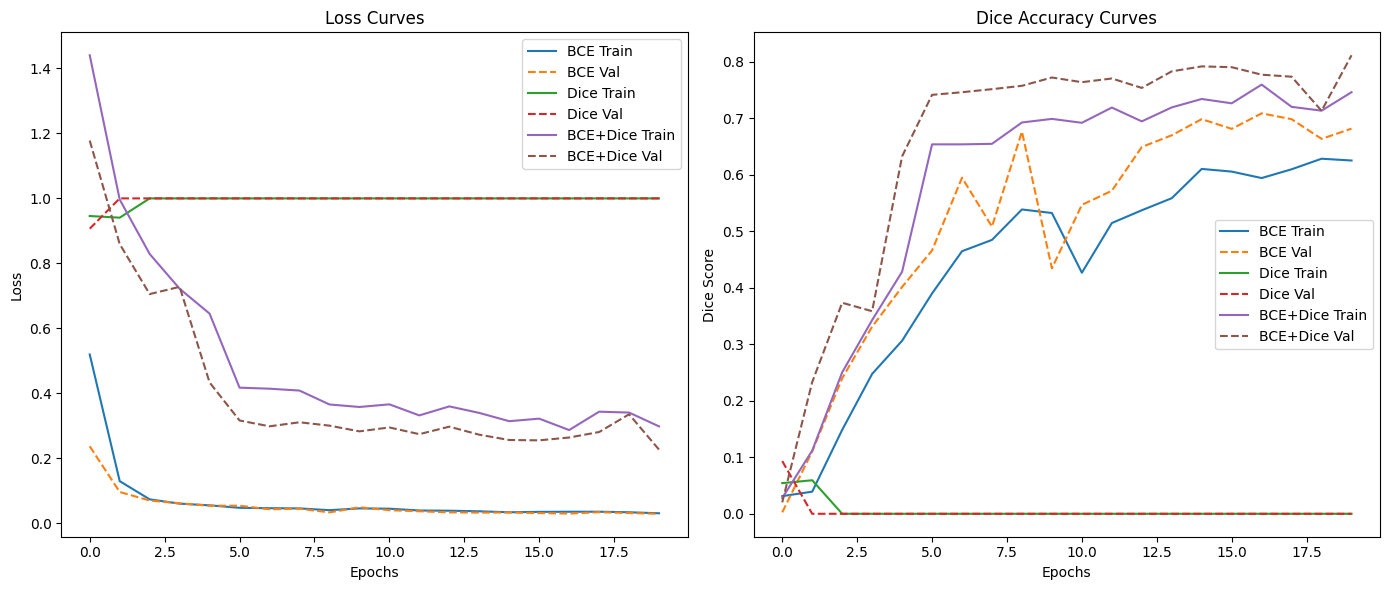

In [ ]:
# --- 4️⃣ Plot Loss/Acc Curves for each loss type ---
plt.figure(figsize=(14,6))

# Loss curves
plt.subplot(1,2,1)
for name in results:
    plt.plot(results[name]['train_losses'], label=f"{name} Train")
    plt.plot(results[name]['val_losses'], linestyle='--', label=f"{name} Val")
plt.title("Loss Curves")
plt.xlabel("Epochs"); plt.ylabel("Loss")
plt.legend()

# Dice curves
plt.subplot(1,2,2)
for name in results:
    plt.plot(results[name]['train_dices'], label=f"{name} Train")
    plt.plot(results[name]['val_dices'], linestyle='--', label=f"{name} Val")
plt.title("Dice Accuracy Curves")
plt.xlabel("Epochs"); plt.ylabel("Dice Score")
plt.legend()

plt.tight_layout()
plt.show()


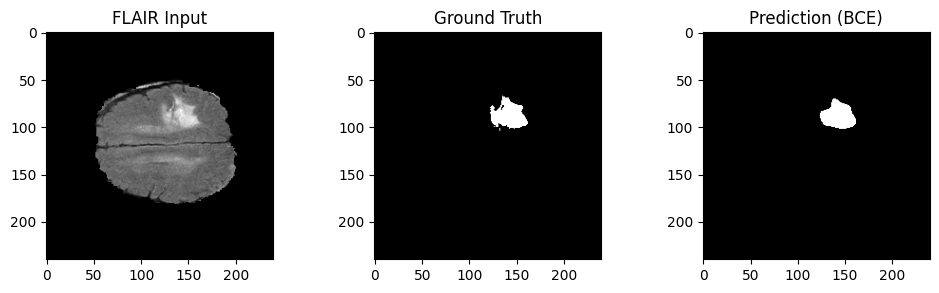

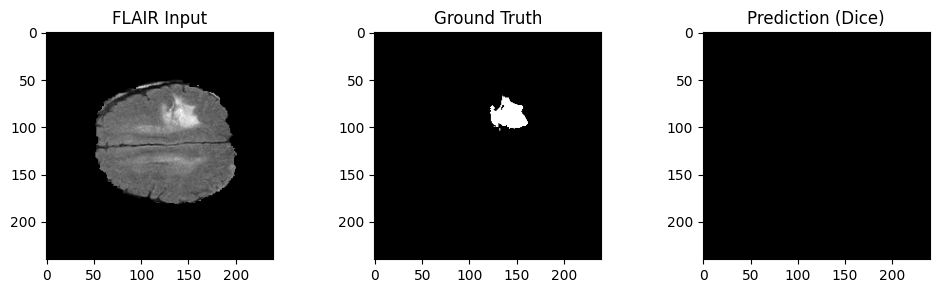

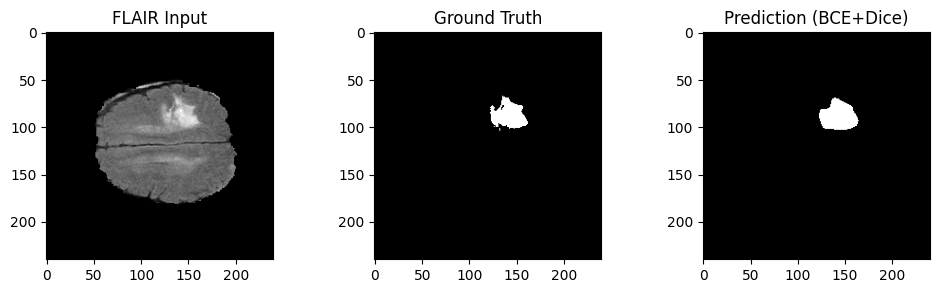

In [ ]:
# --- 5️⃣ Sample Validation Predictions for each trained model ---
#    We take the first batch from val_dataloader and index 0 within it
idx = 5  # first sample from val_dataloader
for name in results:
    model = results[name]['model']
    model.eval()

    X_batch, y_batch = next(iter(val_dataloader))
    X, y = X_batch[idx:idx+1].to(device), y_batch[idx:idx+1].to(device)

    with torch.no_grad():
        pred = torch.sigmoid(model(X)).cpu().squeeze().numpy()
    x = X.cpu().squeeze().numpy()
    y = y.cpu().squeeze().numpy()

    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1)
    plt.imshow(x[0], cmap='gray')
    plt.title('FLAIR Input')

    plt.subplot(1,3,2)
    plt.imshow(y, cmap='gray')
    plt.title('Ground Truth')

    plt.subplot(1,3,3)
    plt.imshow(pred > 0.5, cmap='gray')
    plt.title(f'Prediction ({name})')

    plt.tight_layout()
    plt.show()


# U-Net with Attention

Now we augment the regular UNet with several sub-modules and techniques such as ResNets, Attention modules, etc. We describe the expected architecture for this notebook:

+ *ResNet:* As a base sub-module, we define each ResNet block as two consecutive convolutional layers with a GELU activation in between and Group Normalization after each convolutional layer. You can use this module in Down/Up blocks. Also, by removing the residual connection, you can use this block as a convolutional network throughout the network.
+ *Attention:* This is also a sub-module consisting of a Layer Normalization, Multi-head Attention (use from `torch.nn`), a residual connection, a feed-forward network, and another residual connection.

You can implement the following structure for UNet:

+ Convolutional block
+ Down block
+ Attention
+ Down block
+ Attention
+ Down block
+ Attention

+ Convolutional block (bottleneck)
+ Convolutional block (bottleneck)
+ Convolutional block (bottleneck)

+ Up block
+ Attention
+ Up block
+ Attention
+ Up block
+ Attention
+ Convolutional block

## Modules

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.checkpoint import checkpoint

class ConvResNet(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        # choose groups ≤ channels
        groups = min(8, out_ch)

        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
        self.gn1   = nn.GroupNorm(groups, out_ch)
        self.gelu = nn.GELU()

        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.gn2   = nn.GroupNorm(groups, out_ch)

        # residual skip
        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x):
        identity = self.skip(x)
        x = self.conv1(x)
        x = self.gn1(x)
        x = self.gelu(x)

        x = self.conv2(x)
        x = self.gn2(x)
        return self.gelu(x + identity)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = ConvResNet(in_ch, out_ch)

    def forward(self, x, t=None):
        x = self.pool(x)
        return self.conv(x)

class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)
        self.conv = ConvResNet(in_ch, out_ch)

    def forward(self, x, skip, t=None):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

class AttentionBlock(nn.Module):
    def __init__(self, dim, heads=4, mlp_dim=128, pool_k=4):
        super().__init__()
        self.pool_k = pool_k
        self.norm1  = nn.LayerNorm(dim)
        self.attn   = nn.MultiheadAttention(dim, num_heads=heads, batch_first=True)
        self.norm2  = nn.LayerNorm(dim)
        self.ff     = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, dim)
        )

    def forward(self, x):
        # x: (B, C, H, W)
        B,C,H,W = x.shape

        # 1) Downsample spatially by factor pool_k
        x_small = F.avg_pool2d(x, kernel_size=self.pool_k, stride=self.pool_k)  # (B,C,H/4,W/4)

        # 2) Prepare for MH-Attn
        bs, c, hs, ws = x_small.shape
        N = hs * ws
        flat = x_small.view(bs, c, N).permute(0,2,1)       # (B, N, C)
        normed = self.norm1(flat)

        # 3) Self-attention
        attn_out, _ = self.attn(normed, normed, normed)    # (B, N, C)
        res1 = flat + attn_out

        # 4) FFN with residual
        ff = self.ff(self.norm2(res1))
        res2 = res1 + ff                                   # (B, N, C)

        # 5) Restore spatial dims
        out_small = res2.permute(0,2,1).view(bs, c, hs, ws)  # (B,C,H/4,W/4)
        out = F.interpolate(out_small, size=(H,W), mode='bilinear', align_corners=False)

        # 6) Residual + return
        return x + out

class UNet_Attention(nn.Module):
    def __init__(self, in_ch=4, base_ch=32, num_classes=1):
        super(UNet_Attention, self).__init__()
        self.conv0 = ConvResNet(in_ch, base_ch)            # 240×240 → 32 ch

        self.down1 = Down(base_ch, base_ch * 2)             # → 120×120, 64 ch
        self.attn1 = AttentionBlock(base_ch * 2)

        self.down2 = Down(base_ch * 2, base_ch * 4)         # → 60×60, 128 ch
        self.attn2 = AttentionBlock(base_ch * 4)

        self.down3 = Down(base_ch * 4, base_ch * 8)         # → 30×30, 256 ch
        self.attn3 = AttentionBlock(base_ch * 8)

        self.bottleneck = nn.Sequential(                    # stays 30×30, 256 ch
            ConvResNet(base_ch * 8, base_ch * 8),
            ConvResNet(base_ch * 8, base_ch * 8),
            ConvResNet(base_ch * 8, base_ch * 8),
        )

        # UP path
        self.up1   = Up(base_ch * 8, base_ch * 4)            # 30→60, in 512 ch, out 128 ch
        self.attn4 = AttentionBlock(base_ch * 4)

        self.up2   = Up(base_ch * 4, base_ch * 2)            # 60→120, in 256 ch, out 64 ch
        self.attn5 = AttentionBlock(base_ch * 2)

        self.up3   = Up(base_ch * 2, base_ch)                # 120→240, in 128 ch, out 32 ch
        # ⚠ No high-res attention here  
        self.final = ConvResNet(base_ch, num_classes)       # → 1-channel mask

    def forward(self, x, t=None):
            # contracting
            c0  = self.conv0(x)                       # 240→240
            d1  = checkpoint(self.down1, c0)          # checkpointed
            d1a = checkpoint(self.attn1, d1)
    
            d2  = checkpoint(self.down2, d1a)
            d2a = checkpoint(self.attn2, d2)
    
            d3  = checkpoint(self.down3, d2a)
            d3a = checkpoint(self.attn3, d3)
    
            # bottleneck (3× heavy ConvResNet)
            b = checkpoint(self.bottleneck, d3a)
    
            # expanding
            u1  = checkpoint(self.up1, b, d2a)
            u1a = checkpoint(self.attn4, u1)
    
            u2  = checkpoint(self.up2, u1a, d1a)
            u2a = checkpoint(self.attn5, u2)
    
            u3  = checkpoint(self.up3, u2a, c0)
            out = checkpoint(self.final, u3)
    
            return out

## Train with BCE Loss

The reason behind our choice is **remarkable loss attained by *BCE*** in previous section

In [ ]:
import matplotlib.pyplot as plt

def compute_accuracy(preds, targets, threshold=0.5):
    preds_bin = (preds > threshold).float()
    correct = (preds_bin == targets).float()
    return correct.mean().item()

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    model.train()
    train_loss, train_acc = 0.0, 0.0

    for xb, yb in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        acc  = compute_accuracy(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc  += acc

    train_losses.append(train_loss / len(train_dataloader))
    train_accs.append(train_acc / len(train_dataloader))

    model.eval()
    val_loss, val_acc = 0.0, 0.0

    with torch.no_grad():
        for xb, yb in tqdm(val_dataloader, desc="Validation"):
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            acc  = compute_accuracy(preds, yb)
            val_loss += loss.item()
            val_acc  += acc

    val_losses.append(val_loss / len(val_dataloader))
    val_accs.append(val_acc / len(val_dataloader))

    print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Val Loss={val_losses[-1]:.4f}, "
          f"Train Acc={train_accs[-1]:.4f}, Val Acc={val_accs[-1]:.4f}")


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.29it/s]


Epoch 1: Train Loss=0.2596, Val Loss=0.2217, Train Acc=0.9902, Val Acc=0.9906


Validation: 100%|██████████| 9/9 [00:00<00:00,  9.34it/s]


Epoch 2: Train Loss=0.2270, Val Loss=0.2036, Train Acc=0.9915, Val Acc=0.9914


Validation: 100%|██████████| 9/9 [00:00<00:00,  9.94it/s]


Epoch 3: Train Loss=0.2256, Val Loss=0.1956, Train Acc=0.9916, Val Acc=0.9917


Validation: 100%|██████████| 9/9 [00:00<00:00, 10.20it/s]


Epoch 4: Train Loss=0.1984, Val Loss=0.1844, Train Acc=0.9925, Val Acc=0.9920


Validation: 100%|██████████| 9/9 [00:00<00:00,  9.97it/s]


Epoch 5: Train Loss=0.1992, Val Loss=0.1819, Train Acc=0.9927, Val Acc=0.9922


Validation: 100%|██████████| 9/9 [00:00<00:00, 10.06it/s]


Epoch 6: Train Loss=0.2093, Val Loss=0.1992, Train Acc=0.9924, Val Acc=0.9918


Validation: 100%|██████████| 9/9 [00:00<00:00,  9.74it/s]


Epoch 7: Train Loss=0.2066, Val Loss=0.1811, Train Acc=0.9924, Val Acc=0.9923


Validation: 100%|██████████| 9/9 [00:00<00:00, 10.01it/s]


Epoch 8: Train Loss=0.2033, Val Loss=0.1830, Train Acc=0.9925, Val Acc=0.9924


Validation: 100%|██████████| 9/9 [00:00<00:00,  9.88it/s]


Epoch 9: Train Loss=0.1820, Val Loss=0.1757, Train Acc=0.9934, Val Acc=0.9922


Validation: 100%|██████████| 9/9 [00:00<00:00, 10.04it/s]


Epoch 10: Train Loss=0.1784, Val Loss=0.1640, Train Acc=0.9933, Val Acc=0.9928


Validation: 100%|██████████| 9/9 [00:00<00:00, 10.10it/s]


Epoch 11: Train Loss=0.1678, Val Loss=0.1683, Train Acc=0.9937, Val Acc=0.9928


Validation: 100%|██████████| 9/9 [00:00<00:00,  9.68it/s]


Epoch 12: Train Loss=0.1576, Val Loss=0.1697, Train Acc=0.9941, Val Acc=0.9928


Validation: 100%|██████████| 9/9 [00:00<00:00,  9.88it/s]


Epoch 13: Train Loss=0.1504, Val Loss=0.1839, Train Acc=0.9944, Val Acc=0.9923


Validation: 100%|██████████| 9/9 [00:00<00:00,  9.91it/s]


Epoch 14: Train Loss=0.1414, Val Loss=0.1559, Train Acc=0.9948, Val Acc=0.9933


Validation: 100%|██████████| 9/9 [00:00<00:00,  9.91it/s]


Epoch 15: Train Loss=0.1310, Val Loss=0.1501, Train Acc=0.9950, Val Acc=0.9935


Validation: 100%|██████████| 9/9 [00:00<00:00,  9.88it/s]


Epoch 16: Train Loss=0.1494, Val Loss=0.1975, Train Acc=0.9944, Val Acc=0.9918


Validation: 100%|██████████| 9/9 [00:00<00:00,  9.82it/s]


Epoch 17: Train Loss=0.1411, Val Loss=0.1504, Train Acc=0.9948, Val Acc=0.9935


Validation: 100%|██████████| 9/9 [00:00<00:00,  9.76it/s]


Epoch 18: Train Loss=0.1263, Val Loss=0.1603, Train Acc=0.9952, Val Acc=0.9931


Validation: 100%|██████████| 9/9 [00:00<00:00, 10.14it/s]


Epoch 19: Train Loss=0.1297, Val Loss=0.1508, Train Acc=0.9952, Val Acc=0.9935


Validation: 100%|██████████| 9/9 [00:00<00:00,  9.94it/s]

Epoch 20: Train Loss=0.1426, Val Loss=0.1860, Train Acc=0.9949, Val Acc=0.9923


## Loss Curves & Sample Outputs

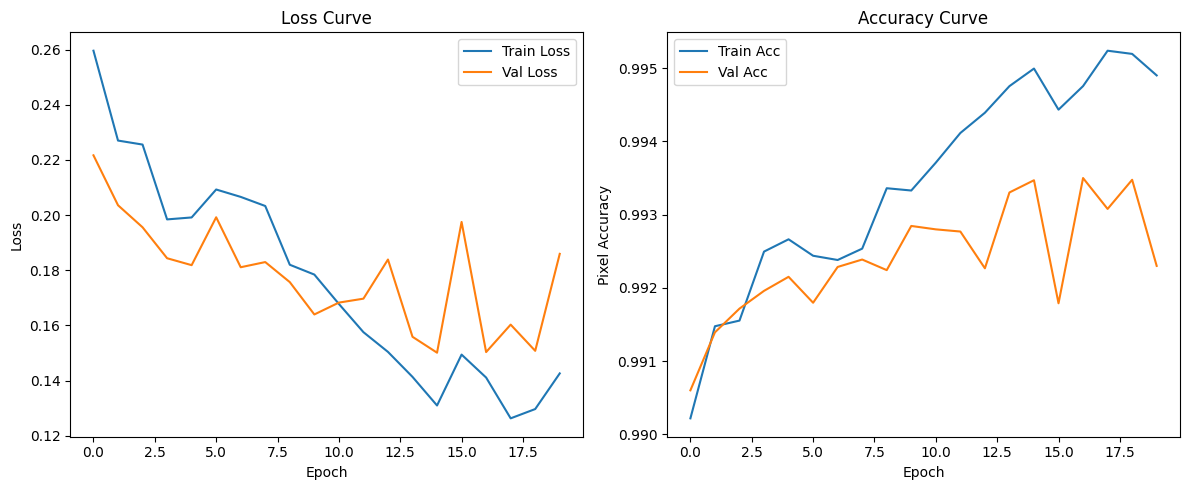

In [ ]:
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs,   label='Val Acc')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Pixel Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


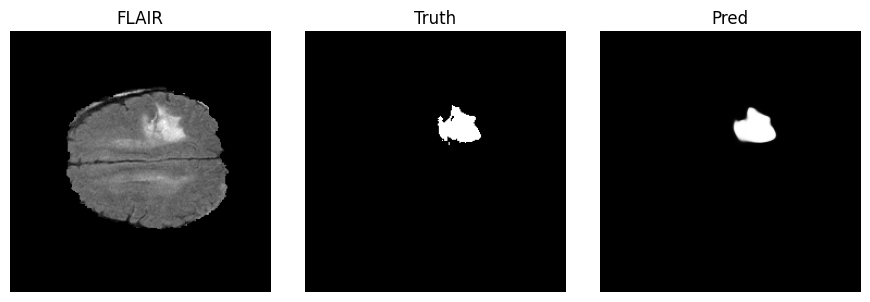

In [ ]:
# Display a sample validation mask
model.eval()
xb, yb = next(iter(val_dataloader))
xb, yb = xb.to(device), yb.to(device)
with torch.no_grad():
    preds = torch.sigmoid(model(xb)).cpu().numpy()
xb, yb = xb.cpu().numpy(), yb.cpu().numpy()

idx = 5
plt.figure(figsize=(9,3))
plt.subplot(1,3,1)
plt.imshow(xb[idx,0], cmap='gray'); plt.title("FLAIR"); plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(yb[idx,0], cmap='gray'); plt.title("Truth"); plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(preds[idx,0], cmap='gray'); plt.title("Pred"); plt.axis('off')
plt.tight_layout(); plt.show()